# Transformation der Daten

In diesem Notebook möchten wir eine Cluster Analyse unserer zuvor vor verarbeiteten Daten durchführen, um inhaltlich ähnliche Filme zu einem Genre zu ordnen zu können. basierend darauf soll eine Ähnlichkeitsanalyse innerhalb jedes Clusters durchgeführt werden, um Vorschläge für ähnliche Titel aussprechen zu können.

## Module importieren

Zur Verarbeitung der Datenbasis werden folgende Module benötigt und müssen zuerst importiert werden.

In [1]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Daten einlesen

In [2]:
PATH_TO_DATA = '../data/movies.json'
# JSON Daten in Dataframe lesen
data = pd.read_json(PATH_TO_DATA)

In [3]:
nlp = spacy.load("en_core_web_sm")

## Datenbereinigung

Entfernen der Dateneinträge ohne Zusammenfassung.

In [4]:
disclaimer = 'It looks like we don\'t have a Synopsis for this title yet.'
for index, movie in data.iterrows():
    if disclaimer in movie['synopsis']:
        data = data.drop(index)
print(len(data))

237


## Vorverarbeitung der Daten

Lemmatisierung der Token, sowie entfernen von Stoppwörtern, Eigennamen und Verben.

In [5]:
processed_data = []
for index, movie in data.iterrows():
    # Vorverarbeiten der Zusammenfassungen
    processed_data.append({'title': movie['title'], 'bow': ' '.join([str(token.lemma_).lower() for token in nlp(movie['synopsis']) if not token.ent_type_ and not token.is_stop and not token.is_punct and token.pos_ != 'VERB'])})
data = pd.DataFrame(processed_data)

Das DataFrame sieht nun folgendermaßen aus:

In [6]:
# Nur erste fünf Einträge anzeigen
data.head()

,title,bow
0,The Shawshank Redemption,banker wife lover golf pro state death penalty...
1,The Dark Knight,movie gang man clown mask bank mob large porti...
2,The Godfather,guest wedding reception daughter connie head f...
3,The Godfather: Part II,godfather ii parallel storyline chief event mo...
4,Pulp Fiction,restaurant young couple pro con bank versus li...


## Feature-Matrix erstellen


Damit wir unsere vorverarbeitenden Bag of Words als Eingabe für unsere Cluster Algorithmus verwenden können erstellen wir eine so genannte Feature Matrix. Dabei generieren wir eine Matrix der Häufigkeit aller Token unsere Dateneinträge mithilfe des von `sklearn`s `CountVectorizer` gefolgt von einer Normalisierung mittels `TfidfTransformer` der Daten. Wir nutzen hierbei die Inverse Dokument Frequency (inverse Dokumentenhäufigkeit). Die inverse Dokumenthäufigkeit misst die Spezifität eines Terms für die Gesamtmenge der betrachteten Dokumente. Ein übereinstimmendes Vorkommen von seltenen Begriffen ist für die Relevanz aussagekräftiger als eine Übereinstimmung bei sehr häufigen Wörtern [[Quelle]](https://de.wikipedia.org/wiki/Tf-idf-Ma%C3%9F).

In [7]:
# Matrix von Token mit Frequenz plus Normalisieren mittels "Inverse-document-frequency" (IDF)
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.2, ngram_range=(1,3))
# Lernen des Vokabulars und IDF
X = vectorizer.fit_transform(data['bow'])

Unsere Feature Matrix besteht somit aus 237 Einträgen, die jeweils über 196 Wörter/Token verfügen. Jeder Dateneintrag besitzt selbstverständlich nicht jedes Wort und hat deshalb bei mehreren Token eine Frequenz von 0.

In [8]:
X.shape

(237, 196)

Wir erhalten folgende Matrix:

In [9]:
X.toarray()

array([[0.0353196 , 0.02406543, 0.        , ..., 0.02499595, 0.07219628,
        0.01581857],
       [0.04885937, 0.02219394, 0.04252334, ..., 0.        , 0.02219394,
        0.02917682],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12084285],
       ...,
       [0.        , 0.        , 0.04800141, ..., 0.        , 0.        ,
        0.06587104],
       [0.        , 0.        , 0.        , ..., 0.07059206, 0.        ,
        0.13402154],
       [0.0483163 , 0.06584177, 0.        , ..., 0.        , 0.        ,
        0.        ]])

Wir erhalten somit 196 Wörter, welche das für dieses Projekt benötigte Vokabular darstellen. Bei einer Optimierung dieses Projekts könnte man beispielsweise dieses Vokabular  (erweitert mit Stoppwörtern, Satzzeichen) anstatt eines der von spaCy zur Verügung gestellten Sprachmodelle nutzen.

In [10]:
# Vokabular
feature_names = vectorizer.get_feature_names()
feature_names

['able',
 'action',
 'actually',
 'alive',
 'angry',
 'apartment',
 'apparently',
 'area',
 'arm',
 'attack',
 'attempt',
 'attention',
 'away',
 'bad',
 'bar',
 'battle',
 'bed',
 'big',
 'black',
 'blood',
 'body',
 'book',
 'boy',
 'brother',
 'building',
 'business',
 'car',
 'case',
 'chance',
 'charge',
 'child',
 'city',
 'close',
 'company',
 'completely',
 'control',
 'conversation',
 'couple',
 'crime',
 'dark',
 'daughter',
 'day',
 'dead',
 'death',
 'despite',
 'different',
 'doctor',
 'door',
 'earlier',
 'end',
 'entire',
 'escape',
 'event',
 'eventually',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'father',
 'fight',
 'film',
 'final',
 'finally',
 'fire',
 'floor',
 'food',
 'foot',
 'force',
 'free',
 'friend',
 'game',
 'girl',
 'good',
 'great',
 'ground',
 'group',
 'guard',
 'gun',
 'hand',
 'happy',
 'hard',
 'head',
 'help',
 'high',
 'home',
 'hospital',
 'house',
 'husband',
 'idea',
 'immediately',
 'information',
 'inside',
 'instead',
 'job',
 'large',


In [11]:
len(feature_names)

196

## k-Means-Clustering

Nachdem wir nun einen validen Input generiert haben, können wir mit dem mit der Modellierung unseres Clustering Algorithmus fortfahren. Wir nutzen hier für den so genannten `k-Means`-Algorithmus, der aus einer Menge von ähnlichen Objekten eine zuvor definierte Anzahl an Clustern bildet. Hierfür nutzen wir ebenfalls `sklearn`. 

Ein gängier Ansatz bei der Evaluierung von Clustering-Algorithmen ist es, den Algorithmus in einer Schleife bis zu einem bestimmten Schwellwert an Clustern auszuführen. Man nutzt dabei eine Metrik, um die Performanz des Algorithmus zu messen. sklearns `inertia` bietet eine Schnittstelle zur Berechnung der `within-cluster sum-of-squares (WSS)` zur Berechnung der Summe der quadrierten Abweichungen von den Cluster-Schwerpunkten. Valide Werte für die Anzahl an Clustern bei unseren Daten sind: 1, ..., 237. 237 Cluster sind dennoch nicht sinnvoll, da wir so jeden Dateneintrag einem eigenen Cluster zuordnen würden. Wir definieren unsere maximale Anzahl an Clustern, welche für uns die verschiedenen Genres der Filmhandlungen darstellen sollen, als 10.

In [12]:
wss = []
limit = 11
for k in range(1, limit):
    model = KMeans(n_clusters=k, max_iter=100)
    model.fit(X)
    wss.append(model.inertia_)

Um eine Aussage zum Wählen einer bestimmten Anzahl an Clustern treffen zu können plotten wir mithilfe von Matplotlib alle WSS. Wir wählen dabei eine Zahl, welche einen "Knick" / niedrigere Steigung aufweist.

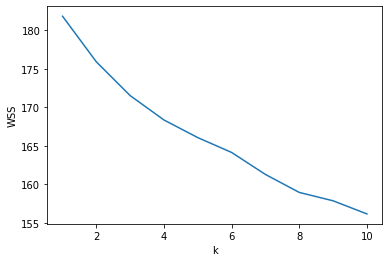

In [13]:
plt.plot(range(1, limit), wss)
plt.xlabel('k')
plt.ylabel('WSS')
plt.show()

## Ergebnisevaluierung

Wir evaluieren unseren Algorithmus auf unseren Daten fortgehend mit einer Anzahl von 7 Clustern/Genren.

In [14]:
k = 7
model = KMeans(n_clusters=k, init='k-means++', max_iter=100)
model.fit(X)

KMeans(max_iter=100, n_clusters=7)

Unser Algorithmus terminiert nach 12 Iterationen.

In [15]:
model.n_iter_

14

WSS aktueller Cluster:

In [16]:
model.inertia_

160.7776604048724

Wir fügen alle Cluster-Zuordnung als neue Spalte in unserem DataFrame an, damit man eine direkte Zuordnung zwischen Filmtitel und Cluster hat.

In [17]:
data['cluster'] = model.labels_.tolist()

In [18]:
data.head()

,title,bow,cluster
0,The Shawshank Redemption,banker wife lover golf pro state death penalty...,0
1,The Dark Knight,movie gang man clown mask bank mob large porti...,0
2,The Godfather,guest wedding reception daughter connie head f...,4
3,The Godfather: Part II,godfather ii parallel storyline chief event mo...,4
4,Pulp Fiction,restaurant young couple pro con bank versus li...,1


## Clustermerkmale


Man kann nun die Eigenschaften eines Clusters untersuchen, in dem man sich die relevantesten Token der einzelnen Cluster anschaut. Dafür iteriert man über jedes einzelne Cluster und gibt eine bestimmte Anzahl an relevantesten Tokens, welche am nächsten zum Mittelpunkt des Clusters sind, aus. Wir können ebenfalls für jedes Cluster ein paar Filme ausgeben, um das Cluster genauer beschreiben zu können.

In [19]:
true_k = np.unique(data['cluster']).shape[0]
# Indizes von Tokens pro Cluster nach Relevanz sortieren
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# 10 wichtigsten Tokens von jeweiligem Cluster ausgeben
for i in range(true_k):
    print("\nCluster {}:\n{}".format(i, ', '.join(feature_names[ind] for ind in order_centroids[i, :15])))


Cluster 0:
police, man, car, room, prison, officer, money, time, guard, job, away, film, building, house, friend

Cluster 1:
car, apartment, man, money, gun, home, time, room, away, police, wife, street, door, friend, life

Cluster 2:
life, letter, story, film, friend, husband, time, wife, love, new, child, man, boy, school, book

Cluster 3:
room, door, voice, away, man, time, new, group, inside, power, suddenly, wall, head, like, large

Cluster 4:
family, father, mother, son, house, daughter, old, child, home, girl, police, wife, young, sister, time

Cluster 5:
man, town, brother, money, girl, son, home, father, house, woman, wife, hand, train, away, local

Cluster 6:
soldier, man, officer, war, father, attack, battle, fire, gun, time, group, train, death, escape, woman


## Clusterzuordnungen

Wir können dann versuchen jedes Cluster durch ein Genre zu beschreiben.

In [20]:
for i in range(len(set(model.labels_))):
    indices = np.where(data['cluster'] == i)[0].tolist()
    print('\nCluster {}: {} Filme\n{}'.format(i, len(indices), ', '.join([data['title'][j] for j in indices[:10]])))


Cluster 0: 24 Filme
The Shawshank Redemption, The Dark Knight, The Usual Suspects, The Departed, The Intouchables, The Dark Knight Rises, Sunset Blvd., Reservoir Dogs, A Clockwork Orange, North by Northwest

Cluster 1: 33 Filme
Pulp Fiction, Fight Club, Inception, Goodfellas, Back to the Future, Léon: The Professional, Joker, Oldboy, The Lives of Others, Andhadhun

Cluster 2: 44 Filme
12 Angry Men, Hamilton, Forrest Gump, Anand, Cinema Paradiso, Casablanca, Avengers: Endgame, Once Upon a Time in America, Memento, Good Will Hunting

Cluster 3: 44 Filme
The Lord of the Rings: The Return of the King, The Lord of the Rings: The Fellowship of the Ring, Terminator 2: Judgment Day, The Lion King, Whiplash, Seven Samurai, Avengers: Infinity War, Spider-Man: Into the Spider-Verse, The Shining, WALL·E

Cluster 4: 32 Filme
The Godfather, The Godfather: Part II, Psycho, Grave of the Fireflies, Gladiator, The Pianist, 3 Idiots, Coco, Dangal, The Hunt

Cluster 5: 36 Filme
Schindler's List, Once Upo

* Cluster 0: Abenteuer
* Cluster 1: Action, Krimi
* Cluster 2: Drama, Krimi
* Cluster 3: Emotionales Drama
* Cluster 4: Action, Abenteuer, Scifi, Krieg
*  Cluster 5: Misteriös, Drama, Krieg
* Cluster 6: Drama, History, Gewalt

Was ebenfalls für die Clusteraufteilung spricht ist der Fakt, dass Sequels mit ähnlicher Story dem gleichen Cluster zugeordnet wurden, siehe beispielsweise: Der Herr der Ringe, der Pate. Trotzdem gibt es ein paar Filme die sich inhaltlich von anderen innerhalb des gleichen Clusters unterschieden, wie beispielsweise Inception und Toy Story.

## Ähnlichkeitsanalyse der Filme eines Clusters

Nachdem wir nun Filme einem bestimmten Schorre zugeordnet haben, können wir die Ähnlichkeiten verschiedene Filme berechnen. Am sinnvollsten ist es Filme des gleichen Clusters zu vergleichen, da diese sich inhaltlich am ähnlichsten sind.

spaCy bietet hierfür eine Methode namens `similarity()`, die die Kosinus Ähnlichkeit zwischen zwei Vektoren (z.B. Token oder Dokumenten) berechnet. spaCy setzt hierfür voraus, dass man ein Sprachmodell verwendet, welches über Wort Vektoren verfügt. Wir importieren deswegen zuerst ein umfangreicheres Sprachmodell.

In [21]:
# Erweitertes Sprachmodel laden (enthält Vekoren)
nlp = spacy.load("en_core_web_lg")

Der folgende Algorithmus berechnet somit für jeden Film in jedem Cluster mit jedem weiteren Film des Clusters dessen Kosinus Ähnlichkeit und speichert diese gerundet in einer Confusion Matrix. Man erhält folgende Tabelle, wobei jede Reihe einen Film darstellt und jede Spalte dessen Änlichkeit zu einem weiteren Film.

In [ ]:
values = []
for i in range(k):
    indices_cluster = data.index[data['cluster'] == i].tolist()
    for j in range(len(indices_cluster)):
        row = {'title': data['title'][indices_cluster[j]]}
        for y in range(len(indices_cluster)):
            row[data['title'][indices_cluster[y]]] = round(nlp(data['bow'][indices_cluster[j]]).similarity(nlp(data['bow'][indices_cluster[y]])), 3)
        values.append(row)
similarity = pd.DataFrame(values)

In [ ]:
similarity

## Min-Max-Normalisierung

Wie man zuvor erkennen konnte, sind die Ähnlichkeiten aller Filme eines Clusters relativ hoch. Dies liegt an der doch größeren Anzahl an selben Wörtern in jeder Zusammenfassung. Es bietet sich daher an alle Ergebnisse zu normalisieren, um ein breiteres Spektrum an Ähnlichkeiten zu erhalten. Die sogenannte Min-Max-Normalisierung bietet sich dafür an. Es wird der minimale- und maximale Wert der Confusion Matrix benötigt:

In [ ]:
minima = min(similarity.min(axis = 1).values)
minima

In [ ]:
maxima = max(similarity.max(axis = 1).values)
maxima

Es wird vorrübergehend die Spalte der Titel entfernt, damit alle Werte Zahlen entsprechen und normalisiert werden können.

In [ ]:
titles = similarity['title']
similarity = similarity.drop(['title'], axis=1)

Anhand der folgenden Formel können unsere Daten normalisiert werden.

In [ ]:
similarity = (similarity - min(similarity.min(axis = 1).values))/(max(similarity.max(axis = 1).values) - min(similarity.min(axis = 1).values))

Wir konkatinieren wiederrum unsere Titel-Spalte mit den nun normalisieren Ähnlichkeiten.

In [ ]:
similarity = pd.concat([titles, similarity], axis=1)
similarity

Alle Werte wurden somit auf einen Wertebereich zwischen 0 und 1 skaliert, wobei 0 einer Ähnlichkeit von 0.788 und 1 einer Ähnlichkeit von 1 entspricht.

## Beispiel: Filmempfehlung

Ein letztes Beispiel soll nun unseren anfänglich definierten Anwendungsfall darstellen. Wir gehen davon aus, dass ein Nutzer den Film Inception angesehen hat, begeistert war und nun einen möglichst ähnlichen Titel schauen möchte. 

Wir identifizieren hierfür den Film Inception in unserer Datenstruktur (in einer realen Anwendung beispielsweise eine Datenbank). Wir transponieren nun unseren Datensatz bestehend aus einem Film und dessen Ähnlichkeiten zu weiteren Filmen aus dem gleichen Cluster, um einen Spaltenvektor zu erlangen. Schlussendlich sortieren wir unsere Liste der Ähnlichkeiten in absteigender Reihenfolge ("Order By"-Statement Datenbank).

Achsen swappen

In [ ]:
inception = similarity.iloc[[0]]
inception = inception.T
inception = inception.drop(inception.index[0])

In [ ]:
inception.sort_values(by=[0], ascending=False)

Wir sind nun in der Lage Vorschläge an inhaltlich ähnlichen Titel auszusprechen. Wir können hierfür eine Reihe von Filmen (siehe Netflix-Beispiel Übersicht) visualisieren oder einen einzelnen Film ausgeben. Man muss beachten, dass man hierbei den gleichen Titel nicht vorschlägt. In einem realen Anwendungsfall könnte man ebenfalls alle Titel, welche der Nutzer bereits gesehen hat, exkludieren. Beispielsweise könnte man dem Nutzer als nächstes den Film: Die Truman Show empfehlen. Dieser passt inhaltlich zu Inception, da in beiden Filmen teilweise um eine Simulation dreht. 

## Fazit

Mithilfe einer durch einen Crawler erstellten Datenbasis, geeigneten Vorverarbeitung der Daten und k-Means Clustering Algorithmus konnten wir unsere Daten bestehend aus Film Zusammenfassungen inhaltlich Clustern. Mithilfe der Kosinus Ähnlichkeit konnten wir alle Filme in einem Cluster vergleichen um letztendlich einen Teil eines realen Anwendungsfalls von Natural Language Processing und Maschinen Learning in Streaming-Anwendungen abzubilden.

* [Zurück zur Übersicht](./0_nlp_intro_schlaak_weise.ipynb)